In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import skew
import igraph
import os
pd.set_option('display.max_columns', 30)

In [3]:
ddir = "/home/scai/PhenPred/data/"
data_folder = "/home/scai/PhenPred/data/clines"

In [4]:
# Import samplesheets
cols = ["model_id", "BROAD_ID", "tissue", "cancer_type"]
col_rename = dict(
    ModelID="BROAD_ID",
    SangerModelID="model_id",
    SampleCollectionSite="tissue",
    OncotreeLineage="cancer_type",
)
ss_cmp = pd.read_csv(f"{data_folder}/model_list_20230505.csv")

ss_depmap = pd.read_csv(f"{data_folder}/depmap24Q4/Model.csv")
ss_depmap.rename(columns=col_rename, inplace=True)

# Map sample IDs to Sanger IDs
samplesheet = pd.concat(
    [
        ss_cmp[cols].dropna().assign(source="sanger"),
        ss_depmap[cols].dropna().assign(source="broad"),
    ]
)
samplesheet = samplesheet.groupby("model_id").first().reset_index()
samplesheet.replace(
    {
        "tissue": dict(
            large_intestine="Large Intestine",
            lung="Lung",
            ovary="Ovary",
            haematopoietic_and_lymphoid_tissue="Haematopoietic and Lymphoid",
            bone_marrow="Other tissue",
            upper_aerodigestive_tract="Other tissue",
            ascites="Other tissue",
            pleural_effusion="Other tissue",
        )
    },
    inplace=True,
)
tissue_map = samplesheet.set_index("model_id").to_dict()["tissue"]

# Growth
growth = pd.read_csv(f"{data_folder}/growth_rate_20220907.csv")
growth = (
    growth.sort_values(["model_id", "replicates"], ascending=False)
    .groupby("model_id")
    .first()
)
growth = growth.dropna(subset=["day4_day1_ratio"])

In [5]:
samplesheet.head()

,model_id,BROAD_ID,tissue,cancer_type,source
0,SIDM00001,ACH-000405,Haematopoietic and Lymphoid,Other Blood Cancers,sanger
1,SIDM00002,ACH-002340,Peripheral Nervous System,Neuroblastoma,sanger
2,SIDM00003,ACH-002159,Skin,Melanoma,sanger
3,SIDM00005,ACH-000044,Breast,Breast Carcinoma,sanger
4,SIDM00006,ACH-001552,Skin,Other Solid Cancers,sanger


In [6]:
samplesheet['tissue'].unique()

array(['Haematopoietic and Lymphoid', 'Peripheral Nervous System', 'Skin',
       'Breast', 'Ovary', 'Large Intestine', 'Esophagus', 'Lung',
       'Head and Neck', 'Central Nervous System', 'Kidney', 'Soft Tissue',
       'Bladder', 'Bone', 'Thyroid', 'Endometrium', 'Stomach', 'Pancreas',
       'Liver', 'Cervix', 'Eye', 'Prostate', 'Biliary Tract', 'Uterus',
       'Testis', 'Other tissue', 'Placenta', 'Small Intestine',
       'Adrenal Gland', 'Vulva', 'Unknown'], dtype=object)

In [7]:
PALETTE_TTYPE = {
    "Lung": "#007fff",
    "Prostate": "#665d1e",
    "Stomach": "#ffbf00",
    "Central Nervous System": "#fbceb1",
    "Skin": "#ff033e",
    "Bladder": "#ab274f",
    "Haematopoietic and Lymphoid": "#d5e6f7",
    "Kidney": "#7cb9e8",
    "Thyroid": "#efdecd",
    "Soft Tissue": "#8db600",
    "Head and Neck": "#e9d66b",
    "Ovary": "#b284be",
    "Bone": "#b2beb5",
    "Endometrium": "#10b36f",
    "Breast": "#6e7f80",
    "Pancreas": "#ff7e00",
    "Peripheral Nervous System": "#87a96b",
    "Cervix": "#c9ffe5",
    "Large Intestine": "#9f2b68",
    "Liver": "#00ffff",
    "Vulva": "#008000",
    "Esophagus": "#cd9575",
    "Biliary Tract": "#72a0c1",
    "Other tissue": "#a32638",
    "Small Intestine": "#9966cc",
    "Placenta": "#f19cbb",
    "Testis": "#e32636",
    "Adrenal Gland": "#3b7a57",
    "Uterus": "#7a3b5e",
    "Unknown": "#a32638",
    "Eye": "#ff1493",
}

In [9]:
timestamp = "20250225_145621"
# Datasets - synthetic
## Transcriptomics
gexp_df = pd.read_csv(
    f"/home/scai/PhenPred/reports/vae/files/{timestamp}_imputed_transcriptomics.csv.gz",
    index_col=0,
)

## CRISPR-Cas9
cas9_df = pd.read_csv(
    f"/home/scai/PhenPred/reports/vae/files/{timestamp}_imputed_crisprcas9.csv.gz",
    index_col=0,
)

In [10]:
mutations_measured = (
            pd.read_csv(f"{data_folder}/mutations_summary_20230202.csv", index_col=0)
            .assign(value=1)
            .query("cancer_driver == True")
        )
mutations_measured = pd.pivot_table(
    mutations_measured,
    index="model_id",
    columns="gene_symbol",
    values="value",
    aggfunc="first",
    fill_value=0,
)

In [11]:
mutations_measured.head()

gene_symbol,ABCB1,ABI1,ABL1,ABL2,ACVR1,ACVR2A,AFF1,AFF3,AJUBA,AKT1,AKT2,AKT3,ALB,ALK,AMER1,...,ZFP36L1,ZFX,ZNF165,ZNF208,ZNF331,ZNF429,ZNF521,ZNF626,ZNF680,ZNF721,ZNF814,ZNF93,ZNRF3,ZRSR2,ZXDB
model_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
SIDM00001,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
SIDM00002,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
SIDM00003,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
SIDM00006,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
SIDM00007,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [12]:
gexp_measured = pd.read_csv(
    f"{data_folder}/depmap24Q4/OmicsExpressionGenesExpectedCountProfileVoom.csv",
    index_col=0,
).T
gexp_measured = gexp_measured.rename(
    index=samplesheet.reset_index().groupby("BROAD_ID").first()["model_id"]
)
gexp_measured = gexp_measured[gexp_measured.index.isin(gexp_df.index)]

In [13]:
## CRISPR-Cas9
cas9_measured = pd.read_csv(
    f"{data_folder}/depmap24Q4/CRISPRGeneEffect.csv", index_col=0
)
cas9_measured.columns = cas9_measured.columns.str.split(" ").str[0]
# cas9_measured = scale(cas9_measured.T).T
cas9_measured = cas9_measured.rename(
    index=samplesheet.reset_index().groupby("BROAD_ID").first()["model_id"]
)
cas9_measured = cas9_measured[cas9_measured.index.isin(cas9_df.index)]

In [14]:
measured_gexp_only = list(set(gexp_measured.index) - set(cas9_measured.index))
measured_cas9_only = list(set(cas9_measured.index) - set(gexp_measured.index))
measured_both = list(set(gexp_measured.index) & set(cas9_measured.index))

In [15]:
measured_groups = {
    "both": measured_both,
    "gexp_only": measured_gexp_only,
    "cas9_only": measured_cas9_only,
    "none": [],  # Will be automatically assigned for remaining samples
}

In [16]:
gexp_df.shape

(1532, 15295)

# MCC with mutation background

In [23]:
gexp_df.head()

,A1BG,A1CF,A2M,A2ML1,A4GALT,AAAS,AACS,AADAC,AADAT,AAGAB,AAK1,AAMDC,AAMP,AAR2,AARD,...,ZSWIM7,ZSWIM8,ZSWIM9,ZUP1,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
SIDM00001,3.03375,-4.45788,-1.90387,-5.49843,0.64732,6.09066,6.01740,-6.07033,-3.35887,6.15852,4.89224,1.91948,6.84024,5.58187,-1.51903,...,2.46568,6.16578,3.77179,4.02192,4.97560,5.67181,7.36821,2.21830,3.93786,4.70484,1.33415,4.30943,5.70952,6.53512,5.24552
SIDM00003,3.12095,-4.58060,4.63499,-4.54927,-0.07416,5.87675,5.35746,-4.54116,2.81654,6.00042,6.03363,2.79657,7.05072,5.72621,-1.08596,...,3.64134,6.50011,3.39244,3.67813,4.86648,5.99124,6.84085,0.95437,3.35363,5.14131,-1.27452,5.29988,7.19922,6.20292,5.97482
SIDM00005,3.93198,-3.40765,0.48378,-2.17494,-0.21163,5.68711,5.51200,-4.74865,1.18680,6.14074,4.90262,3.84388,6.83083,5.56341,-0.57567,...,4.32778,7.09548,3.39066,3.85980,3.92084,5.43321,7.12962,2.32572,4.13165,5.44399,1.31061,5.02422,5.05782,5.99476,5.40781
SIDM00006,1.72700,-4.65080,3.37922,-5.40079,1.70928,5.23166,5.03762,-3.25581,3.36934,6.83576,6.01193,3.43662,6.58317,5.96039,-0.40073,...,3.10803,4.95965,3.13231,4.17283,5.79197,6.81665,6.58061,2.71496,4.18403,3.92374,1.19836,5.77703,7.19312,5.55034,6.66706
SIDM00007,2.19098,-5.27482,1.40571,-5.95245,2.61885,5.41930,5.12508,-2.88867,3.19189,6.73129,6.16523,3.67077,6.73226,5.52950,-1.77032,...,3.13270,5.41410,3.63297,3.96322,5.47132,6.35837,6.26936,2.59028,4.19217,3.87266,1.73008,5.86815,7.26127,5.81302,6.52769


In [17]:
df_res_vae_annot = pd.read_csv(
    f"../reports/vae/crispr/{timestamp}_transcriptomics_crisprcas9_remove_latent_n3_no_tissue_standardizedTrue_annot.csv.gz"
)

In [18]:
df_res_vae_annot.head()

,y_id,x_id,n_orig,beta_orig,lr_orig,covs_orig,pval_orig,fdr_orig,n_vae,beta_vae,lr_vae,covs_vae,pval_vae,fdr_vae,skew_orig,skew_mosa,target_detailed,target,entropy
0,FAM50A,FAM50B,965.0,0.74673,773.48064,208.0,3.147523e-170,5.378802e-166,1532.0,0.62453,797.60789,211.0,1.787104e-175,6.606925e-172,-0.63194,-0.34805,No link; CRISPR not in network,-,0.82357
1,EIF1AX,EIF1AY,965.0,0.68796,609.02971,208.0,1.818819e-134,3.108179e-130,1532.0,0.56248,586.11952,211.0,1.749740e-129,6.468788e-126,0.61614,-0.18150,1,1,0.83241
2,DDX3X,DDX3Y,965.0,0.66294,594.70558,208.0,2.373477e-131,4.056034e-127,1532.0,0.53175,577.08065,211.0,1.618461e-127,5.983451e-124,0.53787,-0.28008,3,3,0.83244
3,DDX3X,UTY,965.0,0.63849,545.35928,208.0,1.286894e-120,2.199174e-116,1532.0,0.50232,515.79778,211.0,3.473738e-114,1.284241e-110,0.53787,-0.28008,3,3,0.83244
4,DDX3X,USP9Y,965.0,0.63052,531.96058,208.0,1.057830e-117,1.807726e-113,1532.0,0.50301,513.37421,211.0,1.169734e-113,4.324508e-110,0.53787,-0.28008,3,3,0.83244


In [126]:
df_res_vae_annot_filtered = df_res_vae_annot.query("entropy > 0.5")
df_res_vae_annot_filtered_top = df_res_vae_annot_filtered.query("fdr_vae < 0.0001")

In [135]:
df_res_vae_annot_filtered_top.shape

(703, 19)

In [136]:
CRISPR_THRESHOLD = -0.5
GEXP_THRESHOLD = 0

In [137]:
def make_sl_binary_matrix(
    gexp_df,
    crispr_df,
    df_res_vae_annot_filtered_top,
    GEXP_THRESHOLD=0,
    CRISPR_THRESHOLD=-0.5,
):
    """
    Returns a binary matrix (DataFrame) of shape (n_samples, n_pairs) where
    1 indicates gexp_df[x_id] < GEXP_THRESHOLD and crispr_df[y_id] < CRISPR_THRESHOLD
    for a given sample.
    """
    samples = gexp_df.index
    col_dict = {}

    for _, row in df_res_vae_annot_filtered_top.iterrows():
        y_id = row["y_id"]
        x_id = row["x_id"]
        col_name = f"{y_id}:{x_id}"

        if (x_id in gexp_df.columns) and (y_id in crispr_df.columns):
            gexp_cond = gexp_df[x_id] < GEXP_THRESHOLD
            crispr_cond = crispr_df[y_id] < CRISPR_THRESHOLD
            col_dict[col_name] = (gexp_cond & crispr_cond).astype(int)
        else:
            # If gene not present, fill with 0s
            col_dict[col_name] = pd.Series(0, index=samples, dtype=int)

    # Create DataFrame from dict
    result = pd.DataFrame(col_dict, index=samples)
    return result

In [138]:
sl_binary_matrix = make_sl_binary_matrix(gexp_df, cas9_df, df_res_vae_annot_filtered_top)

In [139]:
sl_binary_matrix.head()

,FAM50A:FAM50B,EIF1AX:EIF1AY,DDX3X:DDX3Y,DDX3X:UTY,DDX3X:USP9Y,EIF1AX:KDM5D,RPP25L:RPP25,DDX3X:KDM5D,DDX3X:EIF1AY,EIF1AX:UTY,EIF1AX:DDX3Y,DDX3X:ZFY,DDX3X:PRKY,EIF1AX:USP9Y,DDX3X:RPS4Y1,...,SOX10:CPN1,SOX10:RXRG,EWSR1:NEUROD6,SOX10:UCN2,SOX10:GJB1,SOX10:CTXND1,SOX10:ATP10B,TP63:SERPINB13,SOX10:PRDM7,SOX10:ROPN1,SOX10:PMEL,SOX10:S100B,SOX10:PLP1,SOX10:TRIM63,SOX10:MLANA
SIDM00001,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
SIDM00003,0,1,0,0,0,1,0,0,0,1,1,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
SIDM00005,0,1,1,1,1,1,0,1,1,1,1,1,1,1,1,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
SIDM00006,0,1,1,1,1,1,0,1,1,1,1,1,1,1,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
SIDM00007,0,1,1,1,1,1,0,1,1,1,1,1,1,1,1,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [154]:
# Filter mutations to only include columns with more than 50 mutations
mutations_measured_filtered = mutations_measured.loc[:, mutations_measured.sum() > 20]

In [155]:
from sklearn.metrics import matthews_corrcoef
from tqdm import tqdm
import warnings


def pairwise_mcc(sl_binary_matrix, mutations_measured):
    """
    Calculate the pairwise Matthews correlation coefficient (MCC) between columns of
    sl_binary_matrix and columns of mutations_measured.

    Returns a DataFrame of shape (sl_binary_matrix.shape[1], mutations_measured.shape[1])
    """
    # Ensure the indices are aligned
    common_idx = sl_binary_matrix.index.intersection(mutations_measured.index)
    sl_bin = sl_binary_matrix.loc[common_idx]
    muts = mutations_measured.loc[common_idx]

    mcc_matrix = pd.DataFrame(index=sl_bin.columns, columns=muts.columns, dtype=float)

    for sl_col in tqdm(sl_bin.columns, desc="SL columns"):
        for mut_col in muts.columns:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", UserWarning)
                mcc = matthews_corrcoef(sl_bin[sl_col], muts[mut_col])
            mcc_matrix.at[sl_col, mut_col] = mcc

    return mcc_matrix

In [156]:
from sklearn.metrics import matthews_corrcoef
from joblib import Parallel, delayed
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import warnings


def pairwise_mcc(sl_binary_matrix, mutations_measured, n_jobs=-1):
    """
    Calculate the pairwise Matthews correlation coefficient (MCC) between columns of
    sl_binary_matrix and columns of mutations_measured, in parallel.

    Returns a DataFrame of shape (sl_binary_matrix.shape[1], mutations_measured.shape[1])
    """
    # Ensure the indices are aligned
    common_idx = sl_binary_matrix.index.intersection(mutations_measured.index)
    sl_bin = sl_binary_matrix.loc[common_idx]
    muts = mutations_measured.loc[common_idx]

    sl_cols = sl_bin.columns
    mut_cols = muts.columns

    def compute_mcc(sl_col, mut_col):
        x = sl_bin[sl_col].astype("int")
        y = muts[mut_col].astype("int")
        # If either column has only one unique value, MCC is undefined
        if (x.nunique(dropna=True) < 2) or (y.nunique(dropna=True) < 2):
            return np.nan
        try:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", UserWarning)
                return matthews_corrcoef(x, y)
        except ValueError:
            return np.nan

    # Prepare all pairs
    pairs = [(i, j) for i in range(len(sl_cols)) for j in range(len(mut_cols))]

    # Parallel computation
    results = Parallel(n_jobs=n_jobs)(
        delayed(compute_mcc)(sl_cols[i], mut_cols[j])
        for i, j in tqdm(pairs, desc="MCC pairs")
    )

    # Reshape results into DataFrame
    mcc_matrix = np.array(results).reshape(len(sl_cols), len(mut_cols))
    mcc_df = pd.DataFrame(mcc_matrix, index=sl_cols, columns=mut_cols)
    return mcc_df

In [ ]:
mcc_df = pairwise_mcc(sl_binary_matrix, mutations_measured_filtered)

In [158]:
mcc_df.head()

gene_symbol,ACVR2A,APC,ARHGAP35,ARID1A,ARID1B,ARID2,ASXL1,ASXL2,ATF7IP,ATM,ATR,B2M,BAP1,BAX,BCL9L,...,STAG2,STAT5B,STK11,TET2,TGFBR2,TP53,TRRAP,UBR5,USP9X,VHL,WNK2,WNK4,WRN,ZFHX3,ZNF208
FAM50A:FAM50B,0.094339,0.129890,0.024083,0.048176,0.004422,0.046551,0.023319,0.018304,0.040860,0.028050,0.046280,0.071620,-0.037456,0.160966,0.109437,...,-0.048442,0.083473,-0.037781,0.110717,0.015407,-0.027860,0.025803,0.066837,-0.026549,-0.059463,0.054868,0.028683,0.038116,0.025634,0.031693
EIF1AX:EIF1AY,-0.018864,0.034938,0.024574,0.036457,0.012327,-0.004323,-0.091520,0.002641,0.019195,0.045970,-0.008407,-0.001907,0.002641,-0.093445,-0.051488,...,-0.003624,0.033332,0.063432,-0.123236,0.041018,0.101212,-0.009584,0.039494,0.011805,0.037380,0.014573,-0.025718,0.031054,0.033455,-0.001088
DDX3X:DDX3Y,0.041976,0.038323,0.123936,0.124951,0.044911,0.024276,-0.022310,0.031188,0.029336,0.047499,0.017132,0.030191,-0.054290,0.002759,0.008626,...,-0.055650,0.073944,0.142403,-0.055094,0.060106,0.134741,0.029257,0.068977,0.050117,-0.033265,0.017351,0.044107,0.043031,0.055192,0.044911
DDX3X:UTY,0.086577,0.167742,0.093539,0.109861,0.051950,0.046517,-0.043061,0.005853,0.084170,0.052259,0.017356,0.040675,-0.022783,0.010078,0.034993,...,-0.058560,0.083094,0.126349,-0.069838,0.066037,0.133136,0.019055,0.097374,0.049119,-0.023572,0.027771,0.030911,0.027771,0.062894,0.041447
DDX3X:USP9Y,0.082415,0.157806,0.100512,0.106608,0.049700,0.045405,-0.033329,0.011957,0.069859,0.043738,0.023756,0.034455,-0.045013,0.005861,0.022829,...,-0.060528,0.077103,0.118662,-0.075955,0.074295,0.139591,0.028335,0.089545,0.055523,-0.023805,0.034455,0.037239,0.034455,0.064618,0.049700


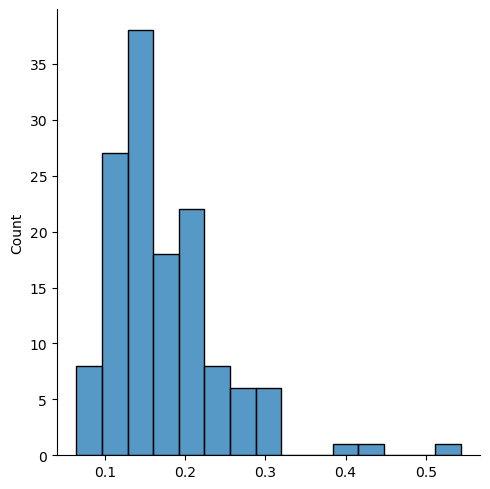

In [159]:
sns.displot(mcc_df.max())

In [160]:
mcc_melt_df = mcc_df.reset_index().melt(
    id_vars="index", var_name="mut_col", value_name="mcc"
)
mcc_melt_df = mcc_melt_df.rename(columns={"index": "CRISPR:GEXP"})

In [161]:
mcc_melt_df_filtered = mcc_melt_df.query("mcc > 0.3").sort_values(
    "mcc", ascending=False
)

In [162]:
mcc_melt_df_filtered.groupby("mut_col").size().sort_values(ascending=False)

mut_col
BRAF      6
EZH2      3
VHL       3
ACVR2A    1
CHD2      1
FAT4      1
QKI       1
RB1       1
dtype: int64

In [163]:
mcc_melt_df_filtered.groupby("CRISPR:GEXP").size().sort_values(ascending=False)

CRISPR:GEXP
WRN:UBE2E2        4
CHMP4B:PTPN6      1
FERMT2:FERMT1     1
HNF1B:FGA         1
HNF1B:SERPINA6    1
EFR3A:ADGRF1      1
MDM2:INPP5D       1
MDM2:SPATA18      1
PAX8:SOX17        1
NMT1:NMT2         1
PSMB6:PSMB9       1
SOX10:ADAMTSL1    1
SOX10:OCIAD2      1
TTC7A:TTC7B       1
dtype: int64

In [172]:
# Split CRISPR:GEXP into y_id and x_id
mcc_melt_df_filtered[['y_id', 'x_id']] = mcc_melt_df_filtered['CRISPR:GEXP'].str.split(':', expand=True)

# Create a mapping dictionary from df_res_vae_annot_filtered_top
fdr_map = {}
for _, row in df_res_vae_annot_filtered_top.iterrows():
    key = f"{row['y_id']}:{row['x_id']}"
    fdr_map[key] = row['fdr_vae']

# Map the fdr_vae values
mcc_melt_df_filtered['fdr_vae'] = mcc_melt_df_filtered['CRISPR:GEXP'].map(fdr_map)
mcc_melt_df_filtered = mcc_melt_df_filtered.drop(columns=["y_id", "x_id"])

In [173]:
mcc_melt_df_filtered

,CRISPR:GEXP,mut_col,mcc,fdr_vae
13958,SOX10:ADAMTSL1,BRAF,0.543571,4.766437e-05
14043,SOX10:OCIAD2,BRAF,0.497735,4.498582e-05
91933,HNF1B:FGA,VHL,0.447232,8.533206e-06
13634,MDM2:INPP5D,BRAF,0.393444,1.347052e-06
92067,HNF1B:SERPINA6,VHL,0.390656,1.507265e-05
34504,NMT1:NMT2,EZH2,0.389861,6.650182e-31
13715,MDM2:SPATA18,BRAF,0.373236,5.664414e-06
13504,FERMT2:FERMT1,BRAF,0.353968,1.825904e-11
92027,PAX8:SOX17,VHL,0.348695,1.718881e-05
21467,WRN:UBE2E2,CHD2,0.317655,3.515328e-05


In [174]:
def plot_scatter_for_row(
    row, gexp_df, cas9_df, mutations_measured, tissue_map, PALETTE_TTYPE
):
    """
    Generates a scatter plot for a given row from mcc_melt_df_filtered.

    Args:
        row (pd.Series): A row from mcc_melt_df_filtered.
        gexp_df (pd.DataFrame): Gene expression data.
        cas9_df (pd.DataFrame): CRISPR screen data.
        mutations_measured (pd.DataFrame): Mutation data.
        tissue_map (dict): Mapping from sample ID (model_id) to tissue type.
        PALETTE_TTYPE (dict): Color palette for tissue types.

    Returns:
        matplotlib.figure.Figure: The generated figure object.
    """
    # --- 1. Extract IDs and data ---
    y_id, x_id = row["CRISPR:GEXP"].split(":")
    mut_col = row["mut_col"]
    mcc_val = row["mcc"]

    # Ensure IDs exist in respective dataframes
    if x_id not in gexp_df.columns:
        print(f"Error: Gene expression ID {x_id} not found.")
        return None
    if y_id not in cas9_df.columns:
        print(f"Error: CRISPR ID {y_id} not found.")
        return None
    if mut_col not in mutations_measured.columns:
        print(f"Error: Mutation column {mut_col} not found.")
        return None

    # --- Get fdr_vae value ---
    fdr_vae_val = row["fdr_vae"]

    # --- 2. Find common samples ---
    # Use tissue_map.keys() since it's a dictionary
    common_samples = (
        set(gexp_df.index)
        & set(cas9_df.index)
        & set(mutations_measured.index)
        & set(tissue_map.keys())  # Corrected to use dict keys
    )

    if not common_samples:
        print("Error: No common samples found for plotting.")
        return None

    common_samples = list(common_samples)

    # --- 3. Prepare plotting dataframe ---
    # Map tissue types using the dictionary
    tissue_types_for_plot = [tissue_map.get(sample) for sample in common_samples]

    plot_df = pd.DataFrame(
        {
            "GEXP": gexp_df.loc[common_samples, x_id],
            "CRISPR": cas9_df.loc[common_samples, y_id],
            "Mutation": mutations_measured.loc[common_samples, mut_col],
            "TissueType": tissue_types_for_plot,  # Use the mapped list
        },
        index=common_samples,  # Assign index explicitly
    ).dropna()  # Drop rows with missing values (e.g., if tissue map had missing keys, though get handles it)

    # Add MutationStatus column for styling
    plot_df["MutationStatus"] = plot_df["Mutation"].apply(
        lambda x: "Mutated" if x == 1 else "Wildtype"
    )

    # --- 4. Create Plot ---
    fig, ax = plt.subplots(figsize=(5, 5))

    # Use ONE scatterplot call with hue and style
    sns.scatterplot(
        data=plot_df,
        x="GEXP",
        y="CRISPR",
        hue="TissueType",
        style="MutationStatus",  # Use the new column for style
        markers={"Wildtype": "o", "Mutated": "X"},  # Define markers
        palette=PALETTE_TTYPE,
        ax=ax,
        s=50,  # Adjust size if needed
        alpha=0.8,
    )

    # --- 5. Customize Plot ---
    ax.set_title(f"{y_id} vs {x_id}\nMutation: {mut_col} (MCC={mcc_val:.3f})")
    ax.set_xlabel(f"{x_id} (GEXP)")  # Updated x-axis label
    ax.set_ylabel(f"{y_id} (CRISPR)")  # Updated y-axis label
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    # Improve legend positioning
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0, ncol=2)

    # Add annotation for sample counts
    n_wt = (plot_df["MutationStatus"] == "Wildtype").sum()
    n_mut = (plot_df["MutationStatus"] == "Mutated").sum()
    annotation_text = f"Samples:\nWildtype: {n_wt}\nMutated: {n_mut}"
    if fdr_vae_val is not None:
        annotation_text += f"\nfdr_vae: {fdr_vae_val:.2e}"
    ax.annotate(
        annotation_text,
        xy=(0.05, 0.95),
        xycoords="axes fraction",
        fontsize=9,
        ha="left",
        va="top",
        bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.5),
    )

    # plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust layout to make space for legend

    return fig

In [175]:
mcc_melt_df_filtered

,CRISPR:GEXP,mut_col,mcc,fdr_vae
13958,SOX10:ADAMTSL1,BRAF,0.543571,4.766437e-05
14043,SOX10:OCIAD2,BRAF,0.497735,4.498582e-05
91933,HNF1B:FGA,VHL,0.447232,8.533206e-06
13634,MDM2:INPP5D,BRAF,0.393444,1.347052e-06
92067,HNF1B:SERPINA6,VHL,0.390656,1.507265e-05
34504,NMT1:NMT2,EZH2,0.389861,6.650182e-31
13715,MDM2:SPATA18,BRAF,0.373236,5.664414e-06
13504,FERMT2:FERMT1,BRAF,0.353968,1.825904e-11
92027,PAX8:SOX17,VHL,0.348695,1.718881e-05
21467,WRN:UBE2E2,CHD2,0.317655,3.515328e-05


In [178]:
mcc_melt_df_filtered.query("`CRISPR:GEXP` == 'TTC7A:TTC7B'")

,CRISPR:GEXP,mut_col,mcc,fdr_vae
34468,TTC7A:TTC7B,EZH2,0.307039,2.085084e-80


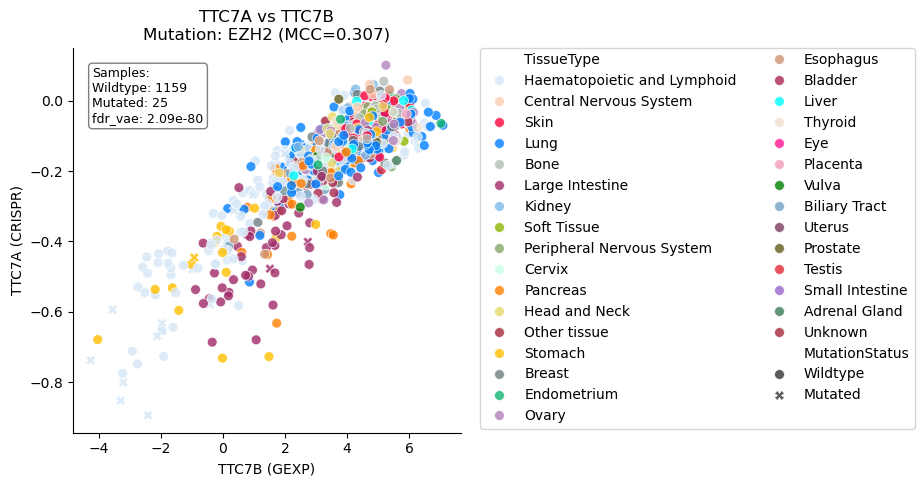

In [180]:
# Call the plotting function
fig = plot_scatter_for_row(
    mcc_melt_df_filtered.query("`CRISPR:GEXP` == 'TTC7A:TTC7B'").iloc[0],
    gexp_df,
    cas9_df,
    mutations_measured,
    tissue_map,
    PALETTE_TTYPE,
)
plt.show()  # Add this line to display the plot in the notebook

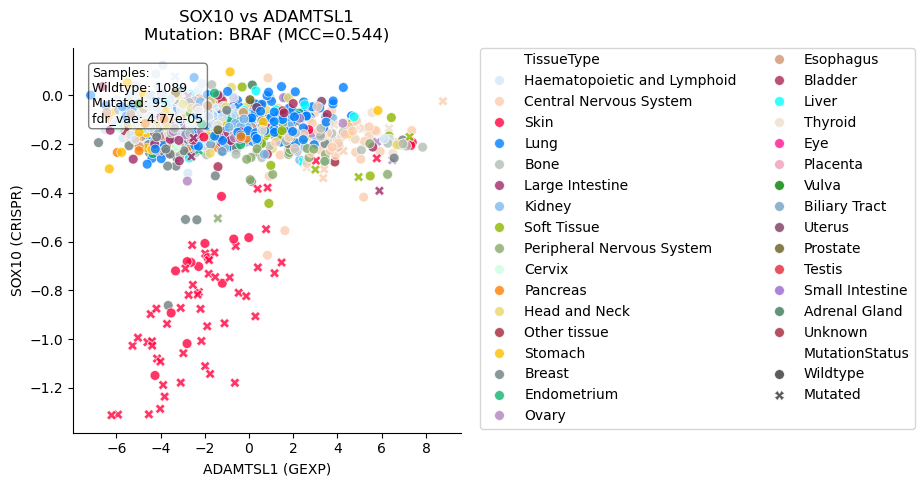

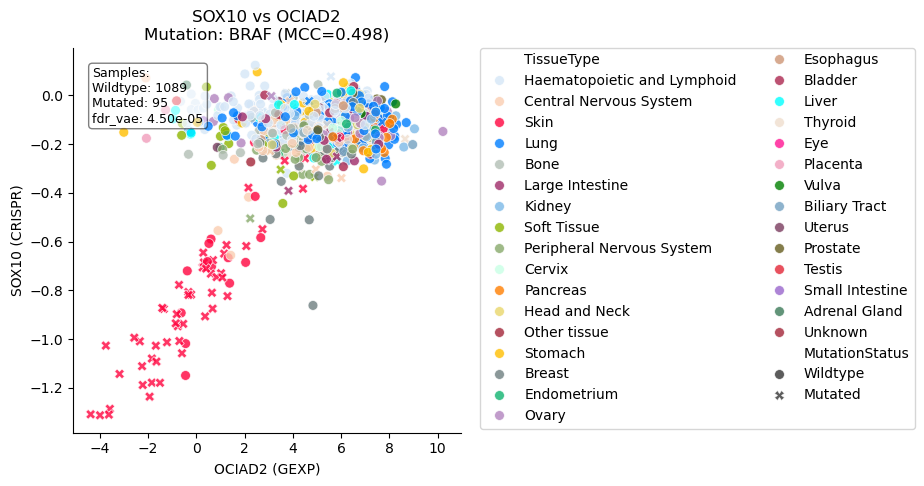

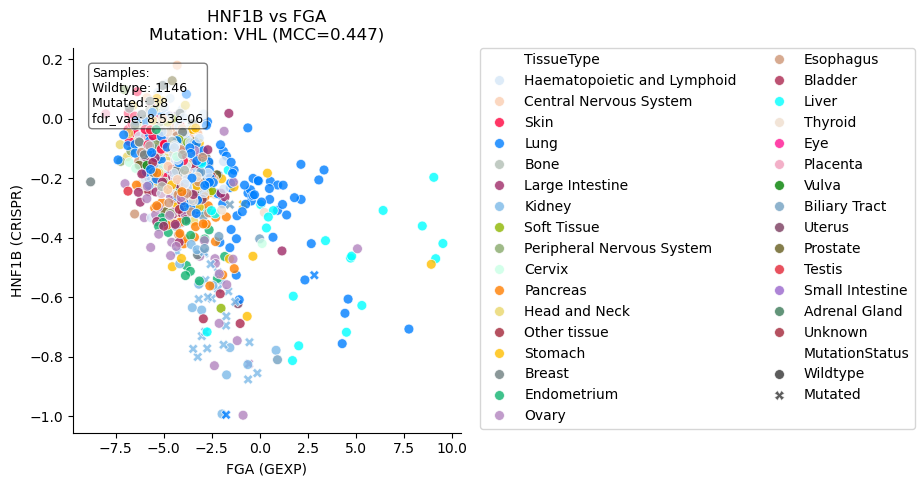

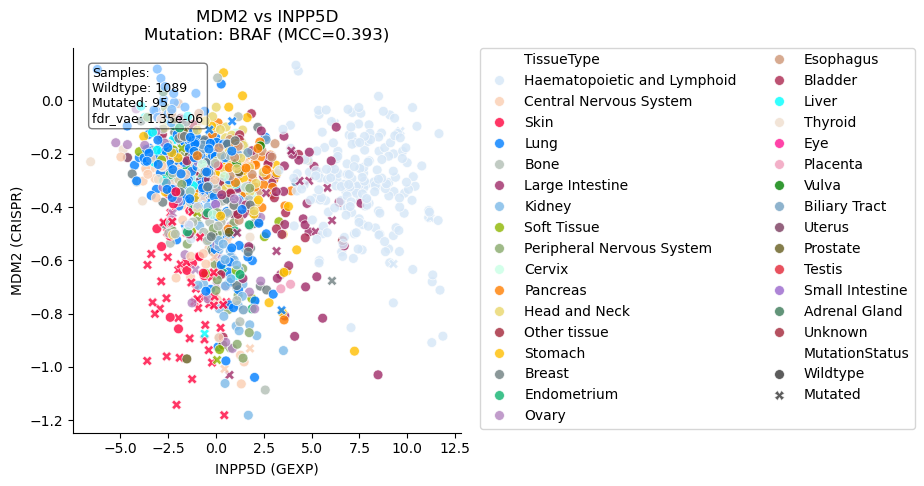

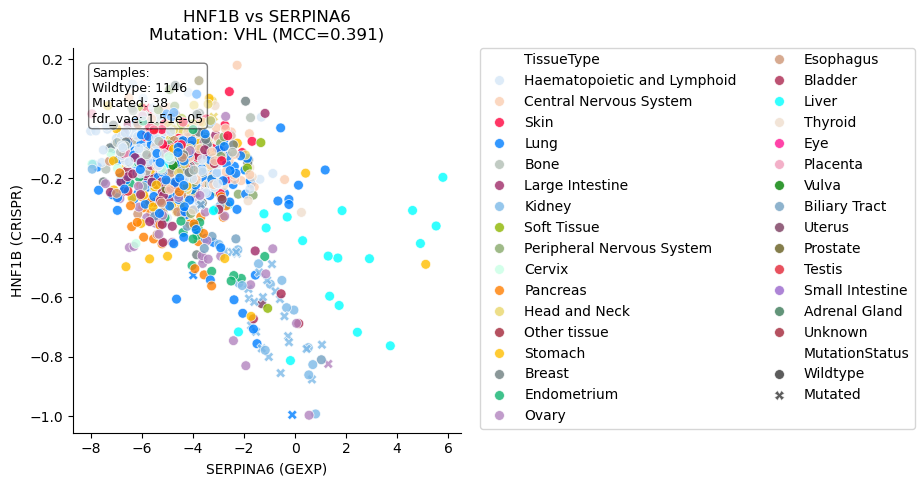

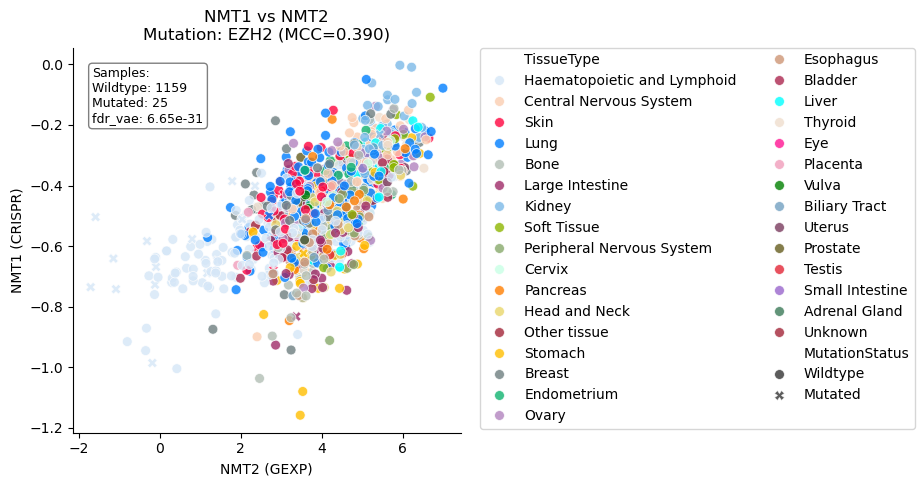

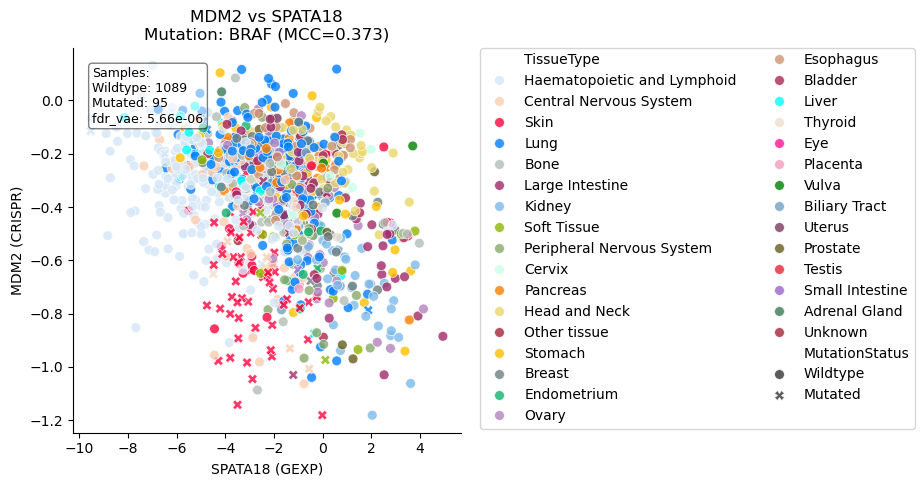

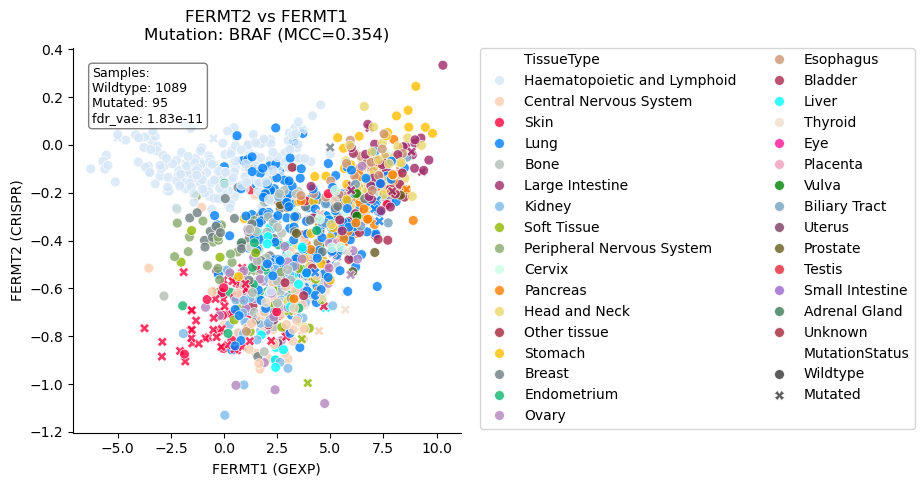

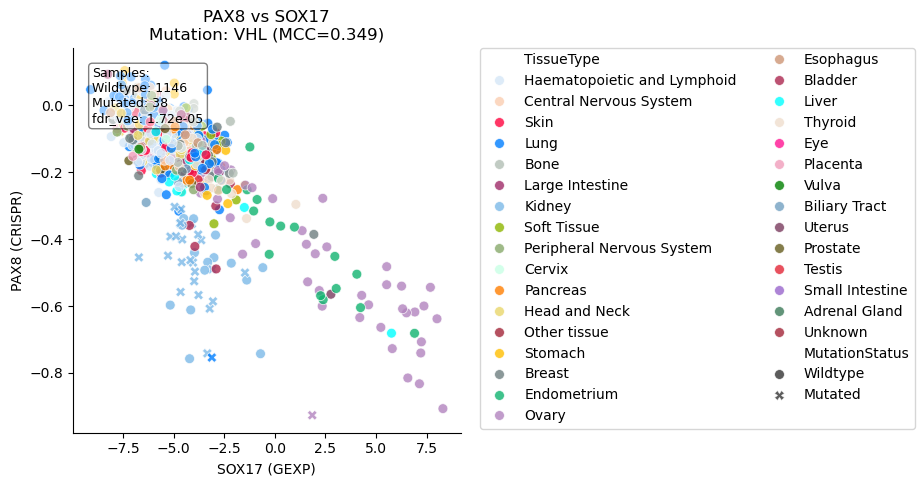

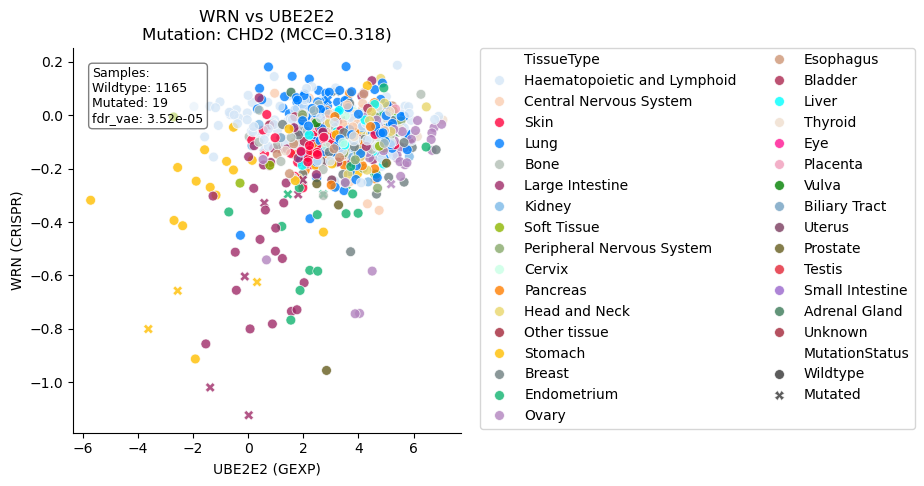

In [170]:
for i in range(10):
    plot_scatter_for_row(
        mcc_melt_df_filtered.iloc[i],
        gexp_df,
        cas9_df,
        mutations_measured,
        tissue_map,
        PALETTE_TTYPE,
    )
    plt.show()  # Add this line to display the plot in the notebook
